In [1]:
import numba
from numba import autojit, jit, float32, int64, void
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import random
from scipy import sparse as sp
import time

import matplotlib.pyplot as plt

/home/jaehun/.local/share/virtualenvs/bpr-numba-F_aeijxL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jaehun/.local/share/virtualenvs/bpr-numba-F_aeijxL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# @jit("f4(i8, i8, i8, f4[:, :], f4[:, :], f4, f4, f4, f4)",
#      nopython=True)
# @autojit
@jit(nopython=True, parallel=True)
def update(u, i, j, W, H, reg_w, reg_h, reg_b, learn_rate):
    """"""
    tmp_wu = W[:, u].copy()
    wu, hi, hj = tmp_wu[:-1], H[:-1, i], H[:-1, j]
    bi, bj = H[-1, i], H[-1, j]
    
    x_uij = 0.
    for r in range(len(hi) + 1):
        x_uij += wu[r] * (hi[r] - hj[r])
    z_uij = 1. / (1. + np.exp(x_uij))
    
    for r in range(len(hi)):
        W[r, u] -= learn_rate * (-z_uij * (hi[r] - hj[r]) + reg_w * wu[r])
        H[r, i] -= learn_rate * (-z_uij * wu[r] + reg_h * hi[r])
        H[r, j] -= learn_rate * (z_uij * wu[r] + reg_h * hj[r])
    H[-1, i] -= learn_rate * (-z_uij + reg_b * bi)
    H[-1, j] -= learn_rate * (z_uij + reg_b * bj)
    
    if z_uij < 0.5:
        return 1.
    else:
        return 0.

# np.argpartition not supported yet.
# is it faster then to use argsort?
@jit("i8[:](i8, f4[:, :], f4[:, :], i8)")
def predict_k(u, W, H, k):
    """"""
    scores = np.zeros((H.shape[-1],), dtype=H.dtype)
    for i in range(H.shape[-1]):
        for r in range(W.shape[0]):
            scores[i] += -W[r, u] * H[r, i]
    # scores = -W[:, u].T.dot(H).ravel()
    ix = np.argpartition(scores, k)[:k]
    return ix[np.argsort(scores[ix])]


# currently dict is not supported by numba
# could use cffi based c hash table such as:
# https://github.com/synapticarbors/khash_numba
# but didn't since it's not elengant in terms of installation
def calculate_apk(train_trues, test_trues, W, H, cutoff):
    """"""
    aps_ = []
    for u in test_trues.keys():
        pred = predict_k(u, W, H, int(cutoff * 10))
        if u in train_trues and len(train_trues[u]) > 0:
            pred = [item
                    for item in pred
                    if item not in train_trues[u]]
        pred = np.array(pred[:cutoff])
        true = np.array(list(test_trues[u]))
        aps_.append(apk(true, pred, cutoff))
    return np.mean(aps_)


@jit("f4[:](f4[:], f4[:, :], b1)", nopython=True)
def forward(xi, theta, relu=False):
    """"""
    logit = theta.dot(xi)
    
    if relu:
        return np.maximum(logit, 0)
    else:
        return logit
    

@jit("f4(f4[:], f4[:], f4, f4[:, :], b1)", nopython=True)
def infer_feature(wu, xi, bi, theta, relu=False):
    """"""
    return wu.T.dot(forward(xi, theta, relu)) + bi


@jit("Tuple((f4, f4[:], f4[:]))(f4[:], f4[:], f4[:], f4, f4, f4[:, :], b1)",
     nopython=True)
def Z_feature(wu, xi, xj, bi, bj, Theta, relu):
    """"""
    hi = forward(xi, Theta, relu)
    hj = forward(xj, Theta, relu)
    X_uij = wu.T.dot(hi - hj) + (bi - bj)
    return 1 / (1 + np.exp(X_uij)), hi, hj


@jit('f4[:, :](f4[:], f4[:])', nopython=True)
def outer_numba(a, b):
    m = a.shape[0]
    n = b.shape[0]
    result = np.zeros((m, n), dtype=a.dtype)
    for i in range(m):
        for j in range(n):
            result[i, j] = a[i]*b[j]
    return result


@jit("f4[:, :](f4, f4[:], f4[:], f4[:], f4[:], f4[:], f4[:, :], f4, b1)",
     nopython=True)
def update_theta(z, wu, xi, xj, hi, hj, Theta, reg, relu):
    """"""
    if relu:
        dTheta = np.zeros(Theta.shape, dtype=Theta.dtype)
        # per factor
        for k in range(Theta.shape[0]):
            if hi[k] > 0 and hj[k] > 0:
                dTheta[k] = -z * wu[k] * (xi.T - xj.T) + reg * Theta[k]

            elif hi[k] > 0 and hj[k] == 0:
                dTheta[k] = -z * wu[k] * xi.T + reg * Theta[k]

            elif hi[k] == 0 and hj[k] > 0:
                dTheta[k] = z * wu[k] * xj.T + reg * Theta[k]

            elif hi[k] == 0 and hj[k] == 0:
                dTheta[k] = reg * Theta[k]
        return dTheta

    else:
        return -z * outer_numba(wu, (xi - xj)) + reg * Theta

    
@jit("f4(i8, i8, i8, f4[:, :], f4[:, :], f4[:, :], f4[:], f8, f8, f8, f8, b1)",
     nopython=True)
def update_feature(u, i, j, W, X, Theta, b, reg_w, reg_th, reg_b, learn_rate, relu):
    """"""
    tmp_W = W.copy()
    wu, xi, xj = tmp_W[:, u], X[:, i], X[:, j]
    bi, bj = b[i], b[j]
    z_uij, hi, hj = Z_feature(wu, xi, xj, bi, bj, Theta, relu)
    
    W[:, u] -= learn_rate * (-z_uij * (hi - hj) + reg_w * wu)
    Theta -= learn_rate * update_theta(z_uij, wu, xi, xj, hi, hj, Theta, reg_th, relu)
    b[i] -= learn_rate * (-z_uij + reg_b * bi)
    b[j] -= learn_rate * (z_uij + reg_b * bj)
    
    if z_uij < 0.5:
        return 1.
    else:
        return 0.

    
@jit("i8[:](i8, f4[:, :], f4[:, :], f4[:, :], f4[:], b1, i8)")
def predict_k_feature(u, W, X, Theta, b, relu, k):
    """"""
    logit = Theta.dot(X)
    if relu:
        H = np.maximum(logit, 0)
    else:
        H = logit

    scores = -(W[:, u].T.dot(H) + b).ravel()
    ix = np.argpartition(scores, k)[:k]
    return ix[np.argsort(scores[ix])]


def calculate_apk_feature(train_trues, test_trues, W, X, Theta, b, relu, cutoff):
    """"""
    aps_ = []
    for u in test_trues.keys():
        pred = predict_k_feature(u, W, X, Theta, b, relu, k=int(cutoff * 2))
        if u in train_trues and len(train_trues[u]) > 0:
            pred = [item
                    for item in pred
                    if item not in train_trues[u]]
        pred = np.array(pred[:cutoff])
        true = np.array(list(test_trues[u]))
        aps_.append(apk(true, pred, cutoff))
    return np.mean(aps_)

    
@jit("f8(i8[:], i8[:], i8)", nopython=True)
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]
    
    score = 0.
    num_hits = 0.
    
    for i, p in enumerate(predicted):
        # if p in actual and p not in predicted[:i]:
        if np.any(actual == p) and np.all(predicted[:i] != p):
            num_hits += 1.0
            score += num_hits / (i + 1.)
    
    # if not actual:
    if len(actual) == 0:
        return 0.
    
    return score / min(len(actual), k)

In [3]:
class BPR:
    """"""
    def __init__(self, n_factors, n_users, n_items, 
                 reg=0.001, n_epochs=1000, learn_rate=0.1,
                 momentum=None, report_every=None, cutoff=40):
        """"""
        # initialize
        self.user_factors = self._init_factors(n_users, n_factors + 1)
        self.user_factors[-1] = 1.  # for bias
        self.item_factors = self._init_factors(n_items, n_factors + 1)
        
        self.n_users = n_users
        self.n_items = n_items
        self.n_epochs = n_epochs
        self.reg = reg
        self.learn_rate = learn_rate
        self.report_every = report_every
        self.cutoff = cutoff
    
    def _init_factors(self, n, r, dtype=np.float32):
        """"""
        factors = np.random.rand(r, n).astype(dtype) - .5
        factors /= r
        return factors
    
    def fit(self, data, test_data=None):
        """"""
        self.users = set(data['user'].unique().tolist())
        self.items = set(data['item'].unique().tolist())
        
        if test_data is not None:
            self.users |= set(test_data['user'].unique().tolist())
            self.items |= set(test_data['item'].unique().tolist())
        
        self.sampler = UserSampler(data, items=list(self.items))
        train_trues = data.groupby('user')['item'].apply(set).to_dict()        
        if test_data is not None:
            test_trues = test_data.groupby('user')['item'].apply(set).to_dict()
            
        self.aps = []
        with tqdm(total=self.n_epochs) as progress:
            for n in range(self.n_epochs):
                correct = 0
                for u, i, j in self.sampler.generate_samples():
                    # update the model
                    correct += update(
                        u, i, j,
                        self.user_factors,
                        self.item_factors,
                        self.reg, self.reg, self.reg,
                        self.learn_rate
                    )

                progress.update(1)
                progress.set_postfix({
                    'correct': '{:.4%}'.format(correct / self.sampler.n_rows)
                })

                if (test_data is not None and
                    self.report_every is not None and
                    n % self.report_every == 0):
                    
                    self.aps.append(calculate_apk(
                        train_trues, test_trues,
                        self.user_factors, self.item_factors,
                        self.cutoff
                    ))
    
    def score(self, data, test_data):
        """"""
        train_trues = data.groupby('user')['item'].apply(set).to_dict()        
        test_trues = test_data.groupby('user')['item'].apply(set).to_dict()
        return calculate_apk(
            train_trues, test_trues,
            self.user_factors, self.item_factors,
            self.cutoff
        )
    

class BPRItemFeature:
    """"""
    def __init__(self, n_factors, n_users, n_items, feature,
                 relu=False, reg=0.001, n_epochs=1000, learn_rate=0.1, 
                 report_every=None, cutoff=40, dtype=np.float32):
        """"""
        # initialize
        self.user_factors = self._init_factors(n_users, n_factors, dtype=dtype)
        self.item_feature = feature.T.astype(dtype)
        self.feature_factor = np.random.randn(
            n_factors, self.item_feature.shape[0]
        ).astype(dtype) * 0.01
        self.bias = np.zeros((n_items,), dtype=np.float32)
                
        self.n_users = n_users
        self.n_items = n_items
        self.n_epochs = n_epochs
        self.reg = reg
        self.learn_rate = learn_rate
        self.report_every = report_every
        self.cutoff = cutoff
        self.relu = relu
    
    def _init_factors(self, n, r, dtype=np.float32):
        """"""
        factors = np.random.rand(r, n).astype(dtype) - .5
        factors /= r
        return factors
    
    def fit(self, data, test_data=None):
        """"""
        self.users = set(data['user'].unique().tolist())
        self.items = set(data['item'].unique().tolist())
        
        if test_data is not None:
            self.users |= set(test_data['user'].unique().tolist())
            self.items |= set(test_data['item'].unique().tolist())
        
        self.sampler = UserSampler(data, items=list(self.items))
        train_trues = data.groupby('user')['item'].apply(set).to_dict()        
        if test_data is not None:
            test_trues = test_data.groupby('user')['item'].apply(set).to_dict()
            
        self.aps = []
        with tqdm(total=self.n_epochs) as progress:
            for n in range(self.n_epochs):
                correct = 0
                for u, i, j in self.sampler.generate_samples():
                    # update the model
                    correct += update_feature(
                        u, i, j,
                        self.user_factors, self.item_feature,
                        self.feature_factor, self.bias,
                        self.reg, self.reg, self.reg,
                        self.learn_rate, self.relu
                    )
               
                progress.update(1)
                progress.set_postfix({
                    'correct': '{:.4%}'.format(correct / self.sampler.n_rows)
                })

                if (test_data is not None and
                    self.report_every is not None and
                    n % self.report_every == 0):
                    
                    self.aps.append(calculate_apk_feature(
                        train_trues, test_trues,
                        self.user_factors, self.item_feature,
                        self.feature_factor, self.bias,
                        self.relu, self.cutoff
                    ))
    
    def score(self, data, test_data):
        """"""
        train_trues = data.groupby('user')['item'].apply(set).to_dict()        
        test_trues = test_data.groupby('user')['item'].apply(set).to_dict()
        return calculate_apk_feature(
            train_trues, test_trues,
            self.user_factors, self.item_feature,
            self.feature_factor, self.bias,
            self.relu, self.cutoff
        )

In [4]:
class UserSampler:
    def __init__(self, data, users=None, items=None):
        self.n_rows = data.shape[0]
        
        if users is None:
            self.users = data['user'].unique()
        else:
            self.users = users
        
        if items is None:
            self.items = data['item'].unique()
        else:
            self.items = items
            
        self.items_set = set(self.items)
        self.pos_set = data.groupby('user')['item'].apply(set).to_dict()
        self.neg_list = {user: list(self.items_set - pos)
                         for user, pos in self.pos_set.items()}
        self.pos_list = {user: list(pos)
                         for user, pos in self.pos_set.items()}
        
        # shuffle items
        for item_list in [self.neg_list, self.pos_list]:
            for user, items in item_list.items():
                np.random.shuffle(items)
        
        # per-user seeker that tracks when the item list to be shuffled
        self.pos_seeker = {user: 0 for user in self.users}
        self.neg_seeker = {user: 0 for user in self.users}
    
    def sample(self, user):
        # get positive sample
        i = self.pos_list[user][self.pos_seeker[user]]
        j = self.neg_list[user][self.neg_seeker[user]]
        self.update_seeker(user)
        return user, i, j

    def generate_samples(self):
        """"""
        user_shuffle_counter = 0
        np.random.shuffle(self.users)
        for _ in range(self.n_rows):
            # retrieve user
            user = self.users[user_shuffle_counter]
            user_shuffle_counter += 1
            
            # shuffle & re-init users
            if user_shuffle_counter == len(self.users):
                np.random.shuffle(self.users)
                user_shuffle_counter = 0
                
            yield self.sample(user)
    
    def update_seeker(self, user):
        if self.pos_seeker[user] + 1 == len(self.pos_list[user]):
            # shuffle list and re-initiate seeker
            np.random.shuffle(self.pos_list[user])
            self.pos_seeker[user] = 0
        else:
            self.pos_seeker[user] += 1

        if self.neg_seeker[user] + 1 == len(self.neg_list[user]):
            # shuffle list and re-initiate seeker
            np.random.shuffle(self.neg_list[user])
            self.neg_seeker[user] = 0
        else:
            self.neg_seeker[user] += 1       

In [5]:
def read_data(fn):
    ll = pd.read_csv(fn, header=None, index_col=None)
    i, j, v = ll[0], ll[1], ll[2]  
    shape = (max(i) + 1, max(j) + 1)
    D = sp.coo_matrix((v, (i, j)), shape=shape).tocsr()
    D.eliminate_zeros()
    return D, ll

data, raw = read_data('../bpr-numba/test.subset.triplet')
# data, raw = read_data('../bpr-numba/lastfm.subset.triplet')
feature = np.load('../bpr-numba/test.subset.X.npy')

In [6]:
DATA = raw
DATA.columns = ['user', 'item', 'value']
USERS = DATA['user'].unique()
ITEMS = DATA['item'].unique()
ITEMS_SET = set(ITEMS)

# split
idx = np.random.permutation(DATA.shape[0])
n_train = int(len(idx) * 0.8)
TRAIN = DATA.iloc[idx[:n_train]]
TEST = DATA.iloc[idx[n_train:]]

## Testing BPR

In [7]:
bpr = BPR(20, n_users=len(USERS), n_items=len(ITEMS),
          reg=0.001, n_epochs=200, learn_rate=0.001,
          report_every=5, cutoff=40)
bpr.fit(TRAIN, TEST)
print('AP@{:d}: {:.4f}'.format(bpr.cutoff, bpr.score(TRAIN, TEST)))

100%|██████████| 200/200 [08:27<00:00,  2.43s/it, correct=80.7035%]


AP@40: 0.0192


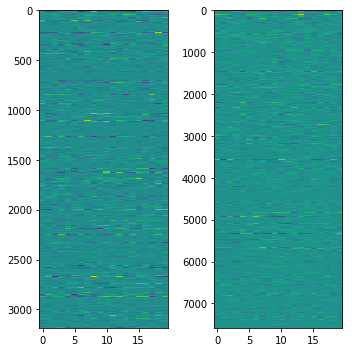

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[0].imshow(bpr.user_factors.T[:,:-1], aspect='auto')
axs[1].imshow(bpr.item_factors.T[:,:-1], aspect='auto')
fig.tight_layout()

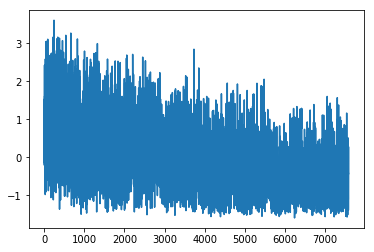

In [9]:
plt.plot(bpr.item_factors[-1])

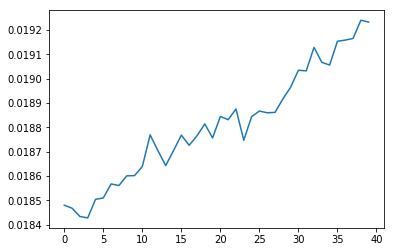

In [10]:
plt.plot(bpr.aps)

## Testing BPRItemFeature

In [110]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(whiten=True)
feature_pca = pca.fit_transform(feature)

sclr = StandardScaler()
feature_z = pca.fit_transform(sclr.fit_transform(feature))

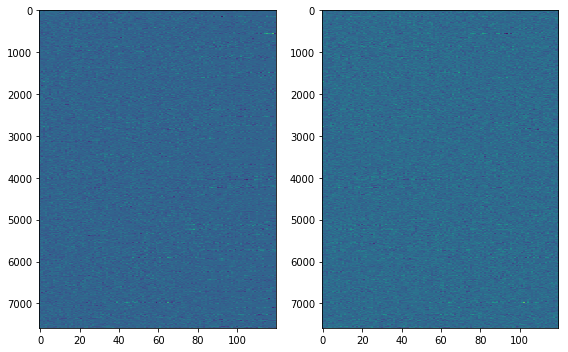

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].imshow(feature_pca, aspect='auto')
axs[1].imshow(feature_z, aspect='auto')
fig.tight_layout()

In [124]:
bpr = BPRItemFeature(20, n_users=len(USERS), n_items=len(ITEMS), 
                     feature=feature_pca, reg=0.001, 
                     n_epochs=100, learn_rate=0.01,
                     report_every=50, cutoff=40, relu=True)
bpr.fit(TRAIN, TEST)
print('AP@{:d}: {:.4f}'.format(bpr.cutoff, bpr.score(TRAIN, TEST)))

100%|██████████| 100/100 [00:27<00:00,  5.78it/s, correct=80.9299%]


AP@40: 0.0169


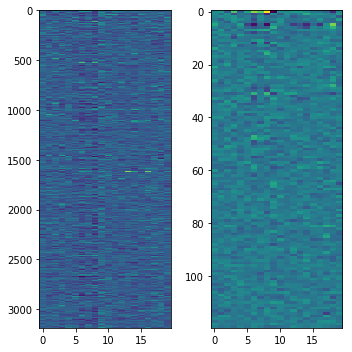

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[0].imshow(bpr.user_factors.T, aspect='auto')
axs[1].imshow(bpr.feature_factor.T, aspect='auto')
fig.tight_layout()

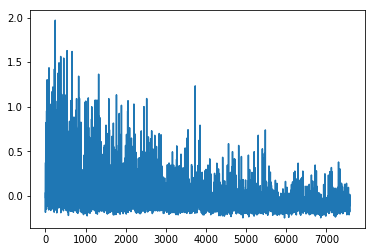

In [126]:
plt.plot(bpr.bias)

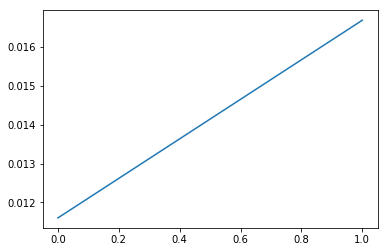

In [127]:
plt.plot(bpr.aps)

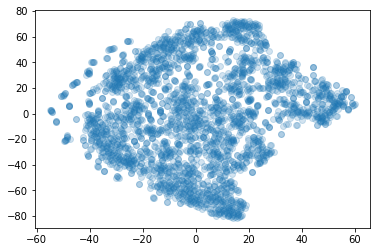

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
H = bpr.item_factors[:, np.random.choice(bpr.n_items, 3000, False)]
# H = bpr.user_factors
v = tsne.fit_transform(H.T)
plt.scatter(v[:, 0], v[:, 1], alpha=0.2)